In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models,layers
from emnist import list_datasets,extract_test_samples,extract_training_samples
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

list_datasets()

x_train, y_train = extract_training_samples('balanced')
x_test, y_test = extract_test_samples('balanced')

In [2]:
# Verileri normalize et
x_train = x_train.squeeze()
x_train = x_train.astype('float32') / 255
x_test= x_test.squeeze()
x_test = x_test.astype('float32') / 255

num_classes = 47

# Etiketleri kategorik hale getir
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [3]:
# Fourier transformu uygulayan ve özellik çıkarımı yapan fonksiyon
def extract_features(images, parameter):
    features = []
    for img in images:
        # Fourier transformunu uygulama
        f_transform = np.fft.fft2(img)
        f_transform_shifted = np.fft.fftshift(f_transform)
        
        # Belirli bir frekans bandını çıkarmak için bir maske oluşturma
        rows, cols = img.shape
        crow, ccol = rows // 2 , cols // 2
        mask = np.zeros((rows, cols), np.uint8)
        size_row = round(crow*parameter)
        size_col = round(ccol*parameter)
        mask[crow - size_row:crow + size_row, ccol - size_col:ccol + size_col] = 1
        
        # Maskeyi uygulama
        f_transform_shifted_filtered = f_transform_shifted * mask
        
        # Özellik vektörüne dönüştürme
        feature_vector = f_transform_shifted_filtered[crow - size_row:crow + size_row, ccol - size_col:ccol + size_col]

        features.append(feature_vector)
        
    return features


In [4]:
x_train_fft = extract_features(x_train, 0.25)
x_test_fft = extract_features(x_test, 0.25)

x_train_fft = np.array(x_train_fft)
x_test_fft = np.array(x_test_fft)

In [5]:
# Kompleks verileri boyutlarını ayarlayalım
x_train_fft = x_train_fft.reshape((x_train_fft.shape[0], -1))
x_test_fft = x_test_fft.reshape((x_test_fft.shape[0], -1))

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [7]:
class ComplexDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(ComplexDense, self).__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        self.kernel_real = self.add_weight(name='kernel_real',
                                           shape=(input_shape[-1], self.units),
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.kernel_imag = self.add_weight(name='kernel_imag',
                                           shape=(input_shape[-1], self.units),
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.bias_real = self.add_weight(name='bias_real',
                                         shape=(self.units,),
                                         initializer='zeros',
                                         trainable=True)
        self.bias_imag = self.add_weight(name='bias_imag',
                                         shape=(self.units,),
                                         initializer='zeros',
                                         trainable=True)

    def call(self, inputs):
        real_inputs = tf.math.real(inputs)
        imag_inputs = tf.math.imag(inputs)

        real_part = tf.matmul(real_inputs, self.kernel_real) - tf.matmul(imag_inputs, self.kernel_imag)
        imag_part = tf.matmul(real_inputs, self.kernel_imag) + tf.matmul(imag_inputs, self.kernel_real)

        outputs = tf.complex(real_part + self.bias_real, imag_part + self.bias_imag)
        if self.activation is not None:
            outputs = self.activation(outputs)
        return outputs

def complex_relu(x):
    real_part = tf.nn.relu(tf.math.real(x))
    imag_part = tf.nn.relu(tf.math.imag(x))
    return tf.complex(real_part, imag_part)

# Complex softmax function approximation
def complex_softmax(x):
    magnitude = tf.abs(x)
    return tf.nn.softmax(magnitude)

class ComplexDropout(tf.keras.layers.Layer):
    def __init__(self, rate):
        super(ComplexDropout, self).__init__()
        self.rate = rate

    def call(self, inputs, training=False):
        if training:
            # Separate real and imaginary parts
            real_inputs = tf.math.real(inputs)
            imag_inputs = tf.math.imag(inputs)
            
            # Apply dropout to real and imaginary parts separately
            real_dropout = tf.nn.dropout(real_inputs, rate=self.rate)
            imag_dropout = tf.nn.dropout(imag_inputs, rate=self.rate)
            
            # Combine the real and imaginary parts back into a complex tensor
            output = tf.complex(real_dropout, imag_dropout)
            return output
        else:
            return inputs
        

class ComplexBatchNormalization(tf.keras.layers.Layer):
    def __init__(self):
        super(ComplexBatchNormalization, self).__init__()
        self.bn_real = tf.keras.layers.BatchNormalization()
        self.bn_imag = tf.keras.layers.BatchNormalization()

    def call(self, inputs):
        real = tf.math.real(inputs)
        imag = tf.math.imag(inputs)
        
        norm_real = self.bn_real(real)
        norm_imag = self.bn_imag(imag)
        
        return tf.complex(norm_real, norm_imag)

In [8]:
input_shape = x_train_fft.shape[1:]

# Giriş katmanı
inputs = Input(shape=input_shape, dtype=tf.complex64)

# Kompleks yoğun katmanlar
x = ComplexDense(64, activation=complex_relu)(inputs)
x = ComplexBatchNormalization()(x)
x = ComplexDense(32, activation=complex_relu)(x)
x = ComplexBatchNormalization()(x)
x = ComplexDense(16, activation=complex_relu)(x)
x = ComplexBatchNormalization()(x)

# Çıkış katmanı
outputs = ComplexDense(num_classes, activation=complex_softmax)(x)

# Modeli oluştur
model = Model(inputs, outputs)

opt=Adam(learning_rate=0.001)

# Modeli derle
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli özetle
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64)]              0         
                                                                 
 complex_dense (ComplexDens  (None, 64)                8320      
 e)                                                              
                                                                 
 complex_batch_normalizatio  (None, 64)                512       
 n (ComplexBatchNormalizati                                      
 on)                                                             
                                                                 
 complex_dense_1 (ComplexDe  (None, 32)                4160      
 nse)                                                            
                                                                 
 complex_batch_normalizatio  (None, 32)                256  

In [9]:
# Modeli eğit
history = model.fit(x_train_fft, y_train, epochs=50, batch_size=32, validation_data=(x_test_fft, y_test), callbacks=[early_stopping])

# Modeli test et
test_loss, test_acc = model.evaluate(x_test_fft, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/50


3525/3525 [==============================] - 37s 7ms/step - loss: 1.5071 - accuracy: 0.5925 - val_loss: 0.8340 - val_accuracy: 0.7488
Epoch 2/50
3525/3525 [==============================] - 25s 7ms/step - loss: 0.8478 - accuracy: 0.7356 - val_loss: 0.7101 - val_accuracy: 0.7801
Epoch 3/50
3525/3525 [==============================] - 21s 6ms/step - loss: 0.7456 - accuracy: 0.7640 - val_loss: 0.6449 - val_accuracy: 0.7959
Epoch 4/50
3525/3525 [==============================] - 19s 5ms/step - loss: 0.6977 - accuracy: 0.7771 - val_loss: 0.6188 - val_accuracy: 0.8064
Epoch 5/50
3525/3525 [==============================] - 25s 7ms/step - loss: 0.6610 - accuracy: 0.7872 - val_loss: 0.6001 - val_accuracy: 0.8132
Epoch 6/50
3525/3525 [==============================] - 28s 8ms/step - loss: 0.6380 - accuracy: 0.7931 - val_loss: 0.5915 - val_accuracy: 0.8132
Epoch 7/50
3525/3525 [==============================] - 24s 7ms/step - loss: 0.6191 - accuracy: 0.7986 - val_loss: 0.5720 - val_

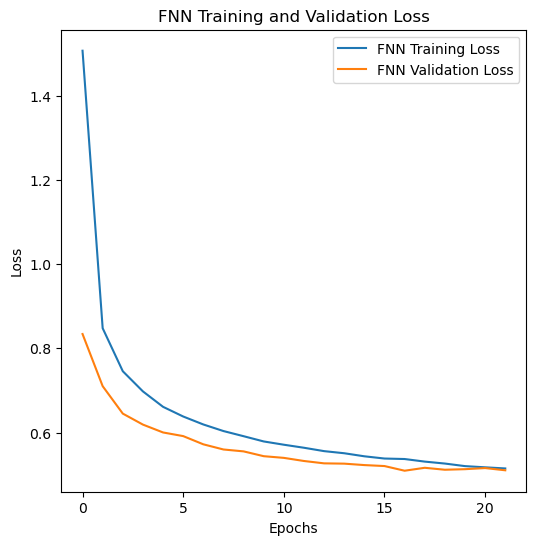

In [10]:
# Eğitim ve Doğrulama Kayıplarını Çizme
plt.figure(figsize=(6, 6))

# FNN Eğitim ve Doğrulama Kayıpları
plt.plot(history.history['loss'], label='FNN Training Loss')
plt.plot(history.history['val_loss'], label='FNN Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('FNN Training and Validation Loss')
plt.legend()

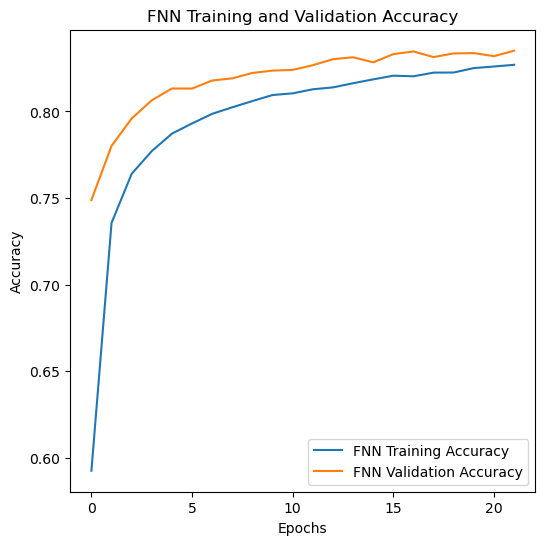

In [11]:
# Eğitim ve Doğrulama Accuracy Çizme
plt.figure(figsize=(6, 6))

# FCNN Eğitim ve Doğrulama Doğruluğu

plt.plot(history.history['accuracy'], label='FNN Training Accuracy')
plt.plot(history.history['val_accuracy'], label='FNN Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('FNN Training and Validation Accuracy')
plt.legend()

In [12]:
x_train_fft2 = extract_features(x_train, 0.33)
x_test_fft2 = extract_features(x_test, 0.33)

x_train_fft2 = np.array(x_train_fft2)
x_test_fft2 = np.array(x_test_fft2)

x_train_fft2 = x_train_fft2.reshape((x_train_fft2.shape[0], -1))
x_test_fft2 = x_test_fft2.reshape((x_test_fft2.shape[0], -1))

In [19]:
input_shape = x_train_fft2.shape[1:]

# Giriş katmanı
inputs = Input(shape=input_shape, dtype=tf.complex64)

# Kompleks yoğun katmanlar
x = ComplexDense(64, activation=complex_relu)(inputs)
x = ComplexBatchNormalization()(x)
x = ComplexDense(32, activation=complex_relu)(x)
x = ComplexBatchNormalization()(x)
x = ComplexDense(16, activation=complex_relu)(x)
x = ComplexBatchNormalization()(x)

# Çıkış katmanı
outputs = ComplexDense(num_classes, activation=complex_softmax)(x)

# Modeli oluştur
model2 = Model(inputs, outputs)

opt=Adam(learning_rate=0.001)

# Modeli derle
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli özetle
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 complex_dense_8 (ComplexDe  (None, 64)                12928     
 nse)                                                            
                                                                 
 complex_batch_normalizatio  (None, 64)                512       
 n_6 (ComplexBatchNormaliza                                      
 tion)                                                           
                                                                 
 complex_dense_9 (ComplexDe  (None, 32)                4160      
 nse)                                                            
                                                                 
 complex_batch_normalizatio  (None, 32)                256 

In [20]:
# Modeli eğit
history2 = model2.fit(x_train_fft2, y_train, epochs=50, batch_size=32, validation_data=(x_test_fft2, y_test), callbacks=[early_stopping])

Epoch 1/50
3525/3525 [==============================] - 29s 6ms/step - loss: 1.5094 - accuracy: 0.5930 - val_loss: 0.8357 - val_accuracy: 0.7465
Epoch 2/50
3525/3525 [==============================] - 21s 6ms/step - loss: 0.8387 - accuracy: 0.7412 - val_loss: 0.6810 - val_accuracy: 0.7891
Epoch 3/50
3525/3525 [==============================] - 21s 6ms/step - loss: 0.7236 - accuracy: 0.7696 - val_loss: 0.6354 - val_accuracy: 0.8011
Epoch 4/50
3525/3525 [==============================] - 20s 6ms/step - loss: 0.6673 - accuracy: 0.7855 - val_loss: 0.5876 - val_accuracy: 0.8106
Epoch 5/50
3525/3525 [==============================] - 21s 6ms/step - loss: 0.6338 - accuracy: 0.7929 - val_loss: 0.5765 - val_accuracy: 0.8163
Epoch 6/50
3525/3525 [==============================] - 22s 6ms/step - loss: 0.6092 - accuracy: 0.7995 - val_loss: 0.5552 - val_accuracy: 0.8193
Epoch 7/50
3525/3525 [==============================] - 22s 6ms/step - loss: 0.5911 - accuracy: 0.8055 - val_loss: 0.5488 - val_ac

In [21]:
# Modeli test et
test_loss, test_acc = model2.evaluate(x_test_fft2, y_test)
print(f"Test accuracy: {test_acc}")

588/588 [==============================] - 2s 3ms/step - loss: 0.4858 - accuracy: 0.8418
Test accuracy: 0.8418084979057312


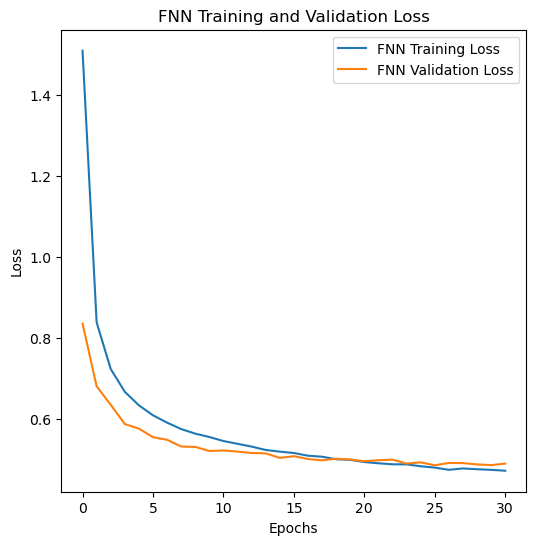

In [22]:
# Eğitim ve Doğrulama Kayıplarını Çizme
plt.figure(figsize=(6, 6))

# FNN Eğitim ve Doğrulama Kayıpları
plt.plot(history2.history['loss'], label='FNN Training Loss')
plt.plot(history2.history['val_loss'], label='FNN Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('FNN Training and Validation Loss')
plt.legend()

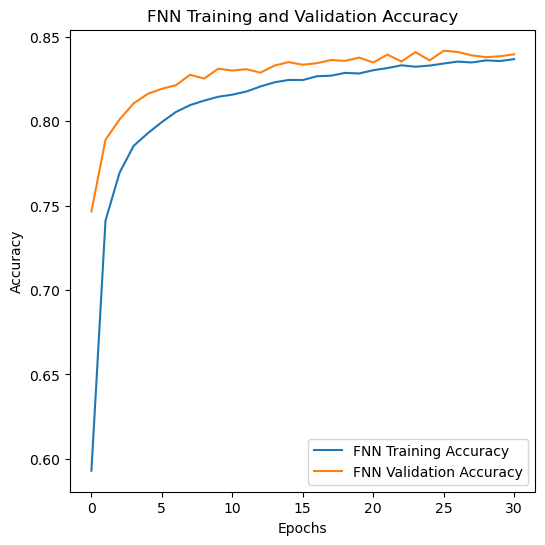

In [23]:
# Eğitim ve Doğrulama Accuracy Çizme
plt.figure(figsize=(6, 6))

# FCNN Eğitim ve Doğrulama Doğruluğu

plt.plot(history2.history['accuracy'], label='FNN Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='FNN Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('FNN Training and Validation Accuracy')
plt.legend()